In [1]:
import numpy as np
from pylab import *
import matplotlib.pyplot as plt
import os
from multiprocessing import Pool
from astropy import units as u
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft
import pymaster as nmt 
from hsc_utils import map_utils as mu
from hsc_utils import stats_code as stats 
from hsc_utils.ST_Jan22 import *
import time
 

#Input parameters/information:
sigma_e = 0.28 ## per component/ sqrt(2) 
zs = ['z1','z2','z3','z4' ,'singlez']

side = 1024  # number of grids
theta = 5.0  # opening angle in deg
map_side_deg = theta*u.degree
pixel_angular_side = map_side_deg /side
theta_smooth = [1,2,3,5,10, 15]  #arcmin 
print(pixel_angular_side)

0.0048828125 deg


In [2]:
def get_sigmae(zz):
    #Read neff/arcmin2
    neff = np.load('/home/gabriela/Documents/Pesquisa/NG_project/data/for_baryons/neff/neff_Heymans2012_'+zz+'.npy' )
    sigma_pix_arr =  (sigma_e / (pixel_angular_side * sqrt(neff/ u.arcmin**2))).decompose().value 
    return sigma_pix_arr


def get_kernel(sig_x, sig_y, Gaussian = False):
    """
    Get kernel for a image with sig_x and sig_y (assuming assymetric). If the kernel is simply Gaussian, set 
    Gaussian = True. Otherwise, it will be the same as Oguri+18
    """
    sigma_x, sigma_y  = sig_x, sig_y
    #print(sigma_x)
    x, y = np.meshgrid(np.linspace(-15,15, int(20*sigma_x)), np.linspace(-15,15, int(20*sigma_y)))
    d = np.sqrt(x*x+y*y)

    exp_part = x**2/(sigma_x**2)+ y**2/(sigma_y**2)
    kernel = 1./(np.pi*sigma_x*sigma_y) * np.exp(-exp_part)
    kernel /= kernel.sum()

    if Gaussian ==True: 
        kernel = Gaussian2DKernel(sig_x, sig_y).array
        kernel/= np.sum(kernel)

    return kernel


def smooth_map(map_in, theta_g):
    smooth_in_pixel = (theta_g/60*u.degree * [np.shape(map_in)[0],np.shape(map_in)[1]] /[theta,theta]).value #.decompose().
    # print(smooth_in_pixel, np.shape(smooth_in_pixel))
    kernel =  mu.get_kernel(smooth_in_pixel[0],smooth_in_pixel[1], Gaussian = False)
    # print(kernel)
    smooth_image = convolve_fft(map_in,kernel)
    return smooth_image




In [3]:

sigma_e = [get_sigmae(z) for z in zs]
np.shape(sigma_e)

(5,)

In [4]:

def add_noise_dark(counter, zz):
    sigma_ei = sigma_e[zz]
    print(sigma_ei)
    #Add white noise:

    filename= '/home/gabriela/Documents/Pesquisa/kappa_TNG_HSC/kappaTNG-Dark_HSCzs/'+zs[zz]+'/kappa%i.npy' % (counter)
    kappa_map = np.load(filename)
    noise_map = np.random.normal(loc=0.0, scale= sigma_ei, size=(side, side))

    kappa_total = kappa_map + noise_map
    #Smooth map:
    k_smoothed = [smooth_map(kappa_total, thetai) for thetai in theta_smooth]

    return k_smoothed


def add_noise_hydro(counter, zz):

    sigma_ei = sigma_e[zz]
    # print(sigma_ei)
    #Add white noise:
    # filename = '/global/cscratch1/sd/gmarques/tng/kappaTNG-Dark_HSCzs/'+zs[zz]+'/kappa%i.npy' % (counter)

    filename= '/home/gabriela/Documents/Pesquisa/kappa_TNG_HSC/kappaTNG-Hydro_HSCzs/'+zs[zz]+'/kappa%i.npy' % (counter)
    kappa_map = np.load(filename)
    noise_map = np.random.normal(loc=0.0, scale= sigma_ei, size=(side, side))

    kappa_total = kappa_map + noise_map
    #Smooth map:
    k_smoothed = [smooth_map(kappa_total, thetai) for thetai in theta_smooth]

    return k_smoothed

In [6]:
ks_dark = add_noise_dark(10, 4)
ks_hydro = add_noise_hydro(10,4)

0.2344066866198806


In [24]:
np.shape(ks_dark )

(6, 1024, 1024)

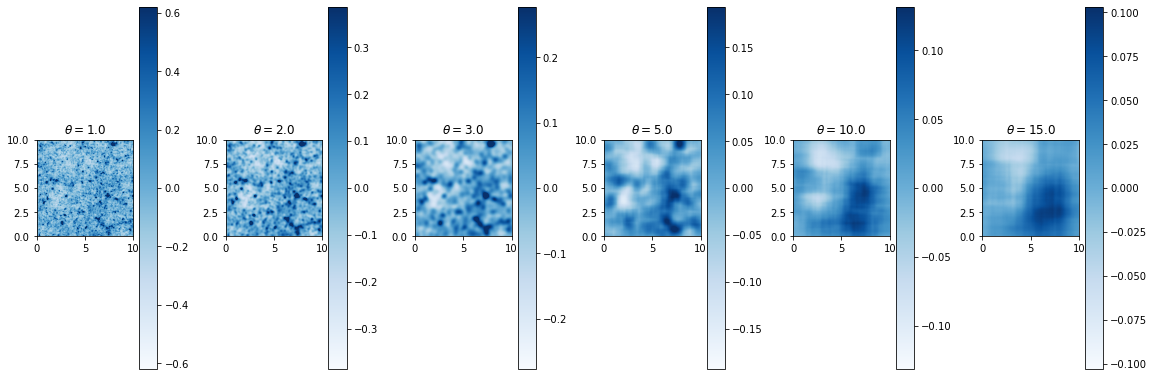

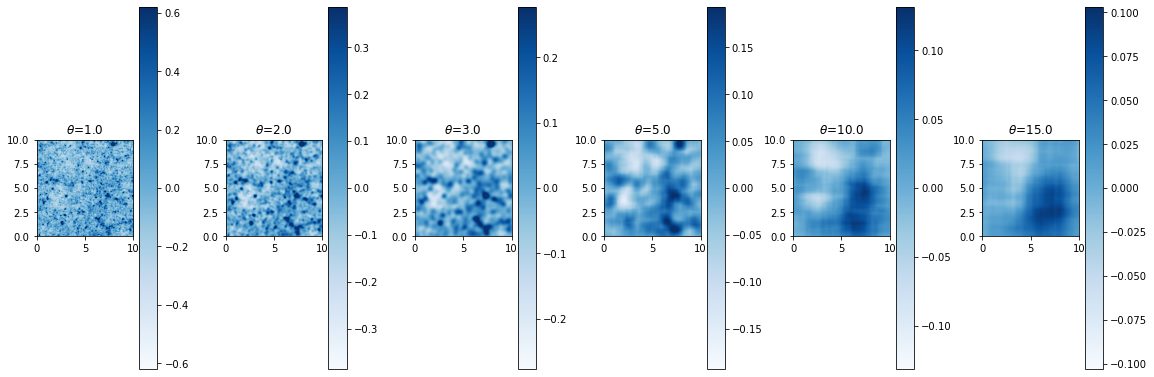

In [25]:
np.shape(ks_dark)

istds_noisy = [ks_dark[i].std() for i in range(6)]
plt.figure(figsize=(16,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    istd = istds_noisy[i]
    plt.imshow(ks_dark[i], vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10], cmap="Blues")
    plt.title(r'$\theta=$%.1f'%(theta_smooth[i]))
    plt.colorbar()
    plt.tight_layout()

plt.figure(figsize=(16,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    istd = istds_noisy[i]
    plt.imshow(ks_hydro[i], vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10], cmap="Blues")
    plt.title(r'$\theta$=%.1f'%(theta_smooth[i]))
    plt.colorbar()
    plt.tight_layout()


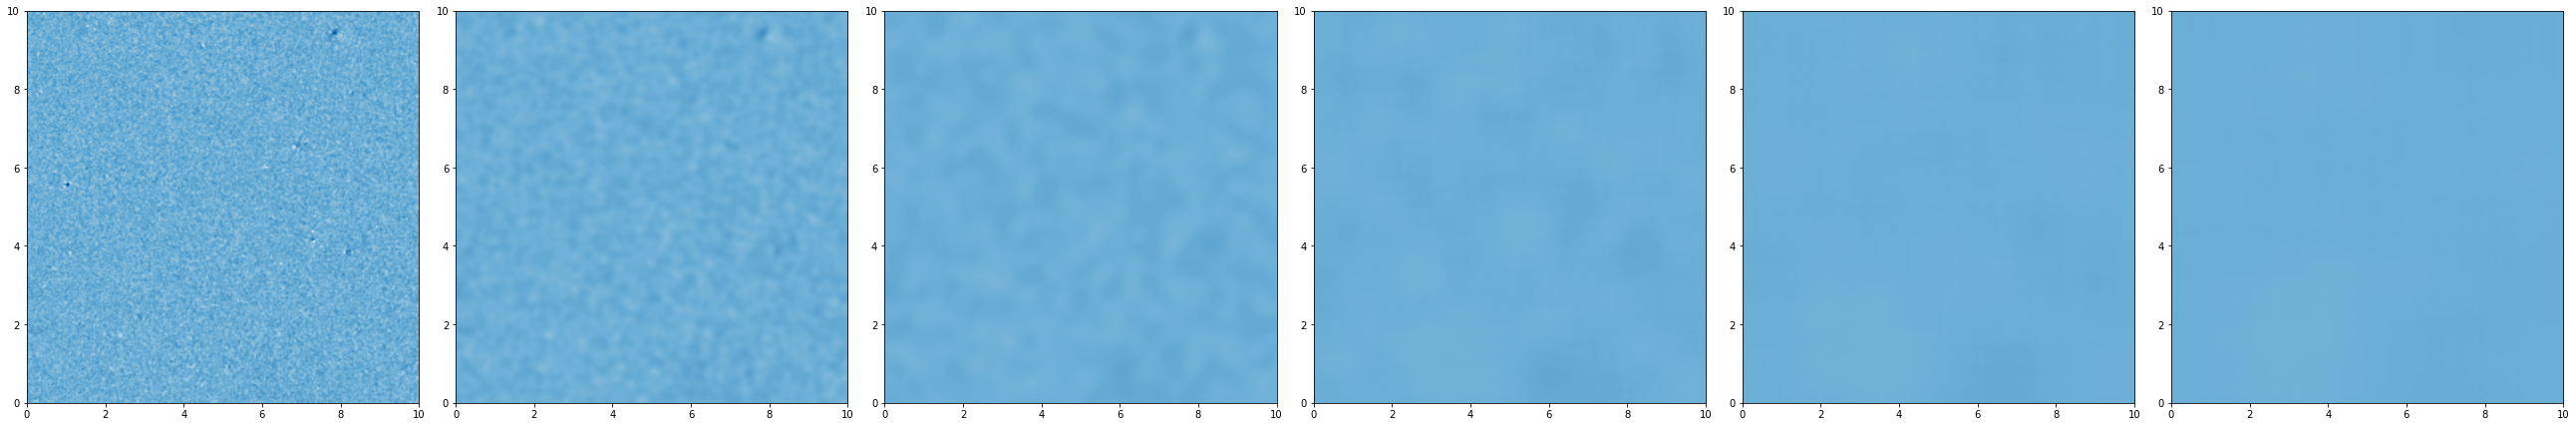

In [27]:
 #See difference between Hydro and Dark: 
plt.figure(figsize=(36,26))
for i in range(6):
    plt.subplot(1,6,i+1)
    istd = istds_noisy[i]
    plt.imshow((ks_hydro[i] -ks_dark[i]), vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10], cmap="Blues")
#     plt.colorbar()
    plt.tight_layout()